In [4]:
# ! pip install numpy==2.1 umap-learn
# ! pip uninstall scikit-learn
# ! pip install scikit-learn
# !pip install pandas --upgrade.

import os
import pandas as pd
import kagglehub
###Testing existing code --https://www.kaggle.com/code/doubeldare704/notebook65dbd5b82a?scriptVersionId=214726330&cellId=1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler
from sklearn.linear_model import SGDOneClassSVM
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
import glob
import matplotlib.pyplot as plt
import re
import ast
import warnings
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

import numpy as np
#from sklearn.svm import SGDOneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.metrics import roc_auc_score
#from tensorflow.keras.layers import Input, Dense, Lambda
#from tensorflow.keras.models import Model
#from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Ensure MinMaxScaler is imported
from sklearn.impute import SimpleImputer
import numpy as np # Ensure numpy is imported

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
os.getcwd()



'/content'

In [6]:
######################################Preprocessing the Data ####################################################
def preprocess_logs(data):
    data2=data[data['argsNum']==1].reset_index()

    # Check if 'index' column exists before dropping
    if 'index' in data2.columns:
        data2.drop(['index'],axis=1,inplace=True)

    def convert_str_to_dict(sample_string):
        # Sample string containing the list
        #sample_string = "[{'name': 'cap', 'type': 'int', 'value': 'CAP_SYS_ADMIN'}]"
        # Regular expression to match the list
        list_pattern = r"\[.*?\]"
        # Extract the list as a string
        list_match = re.search(list_pattern, sample_string)
        extracted_dict = {'name': np.nan, 'type': np.nan, 'value': np.nan} # Initialize with NaN
        if list_match:
            list_string = list_match.group(0)
            #print(list_string)
            # Convert the list string to an actual list
            try:
                extracted_dict = ast.literal_eval(list_string)[0]
            except (SyntaxError, IndexError):
                pass # Keep NaN if parsing fails
            #print("Extracted List:", extracted_list[0])
        else:
            print("No list found in the string.")
        return extracted_dict


    print('Adding new features :  Feature Engineering....')
    #convert_str_to_dict("[{'name': 'cap', 'type': 'int', 'value': 'CAP_SYS_ADMIN'}]")
    data2['args_new']=data2['args'].apply(lambda x: convert_str_to_dict(x))
    new_feats_df = pd.DataFrame(list(data2['args_new']))
    data_3=pd.concat([data2,new_feats_df],axis=1)
    data_3.reset_index(inplace=True)
    data_3.drop(['index'],axis=1,inplace=True)
    data_final=data_3.drop(['args','args_new'],axis=1)


    print('Check if there is any missing value in the data....')
    print(data_final.isnull().sum())
    # Separate numeric and categorical columns
    numeric_columns = data_final.select_dtypes(include=['int64', 'float64','int']).columns
    categorical_columns = data_final.select_dtypes(include=['object']).columns

    print("\nNumeric columns:", numeric_columns.tolist())
    print("Categorical columns:", categorical_columns.tolist())
    columns_to_exclude = ['timestamp','sus','evil']
    df = data_final.loc[:, ~data_final.columns.isin(columns_to_exclude)]
    df.drop(['argsNum'],axis=1,inplace=True)

    ###Preprocess the Mixed Data type Column###
    #import pandas as pd
    # Function to preprocess the column with mixed data types
    def preprocess_mixed_column(df, column_name):
        # Convert to numeric, with errors set to NaN for invalid parsing
        # Check if column exists before processing
        if column_name in df.columns:
            df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
            # Handle NaN values (e.g., fill with 0 or drop rows)
            df[column_name].fillna(0, inplace=True)
            df[column_name].fillna(df[column_name].mode().iloc[0])
            df[column_name]=df[column_name].astype(int)
        else:
            print(f"Warning: Column '{column_name}' not found in DataFrame.")
        return df



    print('Preprocess the Mixed Datatype Column ---')
    df_2 = preprocess_mixed_column(df, 'value')
    df_2
    print('Label Encoding the data...')
    # Encode categorical features
    le_dict = {}
    for col in df_2.columns:
        #print(col)
        le_dict[col] = LabelEncoder()
        df_2[col] = le_dict[col].fit_transform(df_2[col])

    '''# Handle missing values -  can use>>SimleImputerKNNimputer(numeric cols)/mode(categorical cols)
    if len(numeric_columns) > 0:
        data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())
    if len(categorical_columns) > 0:
        data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])'''
    df_3 = pd.concat([data_final[columns_to_exclude],df_2],axis=1)

    print('Sampling 5 % of no suspected data. for purpose of testing on small data size.')
    df_0=df_3[df_3['sus']== 0]
    sampled_df_0 = df_0.sample(frac=0.1, random_state=42)
    df_1=df_3[df_3['sus']== 1]
    final_df=pd.concat([sampled_df_0,df_1],axis=0)
    final_df.reset_index(inplace=True)
    final_df.drop(['index'],axis=1,inplace=True)
    return final_df

#Advantage of whitening the Data -
#--make the features uncorrelated
#-- var = 1,mean=0 means that all features are equally important for training
def Data_Whitening(X):
    # Sample data
    #X = np.array([[1, 2], [3, 4], [5, 6]])
    # Step 1: Center the data
    X_centered = X - np.mean(X, axis=0)
    # Step 2: Compute the covariance matrix
    cov_matrix = np.cov(X_centered, rowvar=False)
    # Step 3: Eigenvalue decomposition
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    # Step 4: Whitening transformation
    X_whitened = np.dot(X_centered, eigvecs @ np.diag(1.0 / np.sqrt(eigvals)))
    print("Original Data:\n", X)
    print("Whitened Data:\n", X_whitened)
    return X_whitened

####################################Out of Data Analysis - OOD #############################################
#UMAP

def UMAP_visual(features,label):
    import umap
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Initialize UMAP with desired parameters
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

    # Fit and transform the data
    embedding = reducer.fit_transform(features)

    # Convert the embedding to a DataFrame for easier plotting
    embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
    embedding_df['label'] = label

    # Plot the UMAP embedding
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='UMAP1', y='UMAP2', hue='label',
        palette=sns.color_palette("hsv", len(np.unique(labels))),
        data=embedding_df,
        legend="full",
        alpha=0.7
    )

    # Add plot title and labels
    plt.title('UMAP Dimensionality Reduction')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.show()
    return embedding_df



#############################################  One-Class SVM  ############################################################
#Only features ,no labels in the below data
#train_1,labels_1,test_1,labels_test_1
#train_1_whitened = Data_Whitening(train_1)

##### Explaining all the parameters :

##nu :helps strike a balance between being too lenient (allowing more errors) and being too strict (fewer support vectors).
      #Upper Bound on Training Errors: This means that nu sets the maximum proportion of data points that can be classified as outliers or errors.
      #Lower Bound on Support Vectors: This implies that at least nu fraction of the training points will be identified as support vectors
##Shuffle : The default value for shuffle is True, meaning the training data will be shuffled after each epoch by default.
##fit_intercept : decides whether the model should include an intercept term, also known as the bias term, in the decision function
                  #model account for the inherent offset in the data, leading to more accurate and flexible decision boundaries.
     #Real-World Data: In real-world scenarios, data often has inherent offsets due to various factors like measurement errors,
    #baseline shifts, or natural biases in the data collection process. Incorporating an intercept term helps the model adjust for these offsets, leading to more accurate predictions.
##tol: This parameter specifies the stopping criterion for the optimization process. The training will stop when the difference in the objective function between iterations is less than this value. The default value is 1e-4.
       #The default value for tol is 1e-4, which means the optimization will stop when the change in the objective function is less than 0.0001.


def SGDSvm(datas,datastest,label):
    ###########Once class SVM with SGD for anomaly detection ##############
     #-----we report AUROC using an ensemble of 5 models for Once class SVM with SGD for anomaly detection
    # Load your cyber security dataset
    # For demonstration, we'll create a sample dataset
    #data = datas  # 1000 samples, 20 features
    #label = label
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(datas)
    data_scaled_test = scaler.fit_transform(datastest)
    # Initialize individual One-Class SVM models with different random states
    models = [
        SGDOneClassSVM(nu=0.1, shuffle=True, fit_intercept=True, random_state=42, tol=1e-4),
        SGDOneClassSVM(nu=0.2, shuffle=True, fit_intercept=True, random_state=43, tol=0.00001),
        SGDOneClassSVM(nu=0.8, shuffle=True, fit_intercept=True, random_state=44, tol=0.00000000000001),
        SGDOneClassSVM(nu=0.6, shuffle=True, fit_intercept=True, random_state=45, tol=0.000000001),
        SGDOneClassSVM(nu=0.4, shuffle=True, fit_intercept=True, random_state=46, tol=0.000000000000000001)
    ]
    # Fit each model to the scaled data
    for model in models:
        model.fit(data_scaled)

    # Predict anomaly scores using each model and aggregate the results
    anomaly_scores = np.zeros((data_scaled_test.shape[0], len(models)))
    for i, model in enumerate(models):
        anomaly_scores[:, i] = model.decision_function(data_scaled_test)
    # Average the anomaly scores across the models
    average_scores = np.mean(anomaly_scores, axis=1)
    # Compute the AUROC score
    auroc = roc_auc_score(label, average_scores)
    print("AUROC Score:", auroc)

    '''# Predict anomalies using each model and aggregate the results
    predictions = np.zeros((data_scaled.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(data_scaled)

    # Anomalies are detected if the majority of models predict -1
    anomaly_votes = np.sum(predictions == -1, axis=1)
    final_predictions = np.where(anomaly_votes > len(models) / 2, -1, 1)
    # Anomalies are labeled as -1
    anomalies = data[final_predictions == -1]
    print("Number of anomalies detected:", len(anomalies))'''
    return True


###################################################  I-FOREST  #################################################
#iForest (Liu et al., 2008) tries to characterise anomalous points in the data distribution using
#an ensemble of “isolation trees”. -- using Bootstrap Aggregation/Bagging.
#iForest performs best at differentiating sus events from the benign in our testing dataset.
    #Usage : #Fraud detection in finance.
            #Network security monitoring.
            #Fault detection in industrial systems

#bootstrap : random sampling with replacement to build each tree in the forest.
#contamination : specifies the proportion of the dataset that is expected to be outliers
#max_Features : determines the number of features to draw from the dataset to train each tree
#max_samples: 'auto'->the number of samples to draw for training each tree is set to the minimum of 256
                #or the number of samples in the dataset. This helps to control the complexity and speed of the algorithm.
#n_Estimators : defines the number of trees in the Isolation Forest (ensemble)
#Anomaly scores : The decision_function provides anomaly scores, which can be valuable for threshold tuning.
#                 You can set a threshold based on these scores to classify anomalies and normal points more flexibly.

###Note : Since anomalies are rare, accuracy might not be the most informative metric, hence use F1 scores.

def I_forest(train_data,test_data,labels_test_data):
    # Define the parameter grid
    param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': ['auto', 0.5, 0.7, 1.0],
    'contamination': [0.05, 0.1, 0.15],
    'max_features': [8, 10, 12],
    'bootstrap': [True, False]
    }
    # Create Isolation Forest model
    isolation_forest = IsolationForest(random_state=42)
    # Create GridSearchCV object
    grid_search = GridSearchCV(estimator=isolation_forest, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

    #train data
    ####train_1,labels_1,test_1,labels_test_1
    X = train_data
    X_test = test_data
    # Fit the model to the data
    grid_search.fit(X)

    # Get the best parameters and the best model
    best_params = grid_search.best_params_
    print(f"The best params in I-forest : {best_params}")
    best_model = grid_search.best_estimator_
    print(f"The best model in I-forest : {best_model}")

    # Predict anomalies (-1 for anomalies, 1 for inliers) with the best model
    predictions = best_model.predict(X_test)
    # Get anomaly scores
    anomaly_scores = best_model.decision_function(X_test)

    # Print results
    print("Best Parameters:", best_params)
    print("Predictions:", predictions)
    print("Anomaly Scores:", anomaly_scores)

    auroc = roc_auc_score(labels_test_data, anomaly_scores)
    print("AUROC Score:", auroc)

    return True

  ##############################################   ##`Dimensionality reduction using VAE followed by Training One-Class SVM with SGD` Function:###########################################
    #   This function defines the architecture of the Variational Autoencoder. A VAE consists of two main parts: an Encoder and a Decoder.
    #   ##Encoder:##
        #   `inputs = Input(shape=(input_dim,))`: Defines the input layer with the shape matching the number of features in the data.
        #   `h = Dense(64, activation='relu')(inputs)`: The first hidden layer in the encoder. It's a fully connected layer with 64 neurons and 'relu' (Rectified Linear Unit) activation.
        #   `h = BatchNormalization()(h)`: Adds Batch Normalization. This layer helps stabilize training and can improve performance by normalizing the outputs of the previous layer across the batch.
        #   `z_mean = Dense(latent_dim)(h)`: A dense layer that outputs the #mean# of the latent distribution. The number of neurons equals the desired `latent_dim`.
        #   `z_log_var = Dense(latent_dim)(h)`: A dense layer that outputs the #log variance# of the latent distribution. Log variance is often used instead of variance for numerical stability.
    #   ##Reparameterization Trick:##
        #   This is a key part of VAEs. Instead of directly sampling from the latent distribution (which is not differentiable and prevents backpropagation), we sample from a standard normal distribution (epsilon) and then shift and scale it using the predicted mean (`z_mean`) and log variance (`z_log_var`).
        #   `def sampling(args): ...`: Defines the sampling logic.
        #   `epsilon = tf.keras.backend.random_normal(shape=(batch, latent_dim))`: Generates random noise from a standard normal distribution.
        #   `return z_mean + tf.exp(0.5 # z_log_var) # epsilon`: This is the reparameterization: `mean + std_dev # epsilon`. `tf.exp(0.5 # z_log_var)` calculates the standard deviation from the log variance.
        #   `z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])`: Creates a `Lambda` layer that applies the `sampling` function to the `z_mean` and `z_log_var` outputs. `z` represents the sampled point in the latent space.
    #   ##Decoder:##
        #   `decoder_h = Dense(64, activation='relu')`: Defines the first hidden layer in the decoder (which will be applied to the latent variable `z`).
        #   `decoder_h_bn = BatchNormalization()(z)`: Batch normalization applied to the latent variable `z`.
        #   `h_decoded = decoder_h(decoder_h_bn)`: Applies the decoder hidden layer.
        #   `x_decoded_mean = Dense(input_dim, activation='sigmoid')(h_decoded)`: The output layer of the decoder. It aims to reconstruct the original input. The number of neurons equals the `input_dim`. `sigmoid` activation is used, which outputs values between 0 and 1. This suggests the original input features are expected to be in this range (hence the need for `MinMaxScaler` before training).
    #   ##VAE Model:##
        #   `vae = Model(inputs, [x_decoded_mean, z_mean, z_log_var])`: Defines the full VAE model. It takes the original `inputs` and outputs the reconstructed data (`x_decoded_mean`), the latent mean (`z_mean`), and the latent log variance (`z_log_var`). The `z_mean` and `z_log_var` outputs are needed for the VAE loss calculation.
    #   ##`vae_loss(y_true, y_pred)` Function:##
        #   This custom loss function for the VAE combines two components:
            #   ##Reconstruction Loss:## Measures how well the decoder reconstructs the input data. `tf.keras.losses.binary_crossentropy(x_true, x_decoded_mean)` calculates the binary crossentropy between the original input (`x_true`) and the reconstructed output (`x_decoded_mean`). Binary crossentropy is suitable when the output is in the range [0, 1] (due to the sigmoid activation) and can be interpreted as probabilities or normalized values.
            #   ##KL Divergence Loss:## Measures the difference between the learned latent distribution (parameterized by `z_mean` and `z_log_var`) and a standard normal distribution (the prior). Minimizing this term encourages the latent space to be well-structured and allows for generating new samples. The formula `-0.5 # K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)` calculates the KL divergence per sample.
        #   `return K.mean(reconstruction_loss_per_sample_summed + kl_loss)`: The total VAE loss is the sum of the reconstruction loss and the KL divergence loss, averaged over the batch.
    #   ##Compile the Model:##
        #   `optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)`: Defines the optimizer used to update the model's weights during training. RMSprop is a popular adaptive learning rate optimizer. A small learning rate (0.001) is chosen.
        #   `vae.compile(optimizer=optimizer, loss=vae_loss)`: Configures the model for training by specifying the optimizer and the custom `vae_loss` function.
    #   ##Encoder Model:##
        #   `encoder = Model(inputs, z_mean)`: Defines a separate model that takes the original `inputs` and outputs just the `z_mean` (the learned latent representation). This model will be used to extract
#Sources


# Define VAE architecture

# Define VAE architecture with nested functions
def build_vae(input_dim, latent_dim):
    def encoder(inputs):
        h = Dense(64, activation='relu')(inputs)
        # Add Batch Normalization after the first Dense layer
        h = BatchNormalization()(h)
        #learned embeddings are compressed to lower dim space :latent representation
        z_mean = Dense(latent_dim)(h)
        z_log_var = Dense(latent_dim)(h)
        return z_mean, z_log_var

    # Reparameterization: sample from latent distribution
    def sampling(z_mean, z_log_var):
        def sample_fn(args):
            z_mean, z_log_var = args
            batch = tf.shape(z_mean)[0]
            epsilon = tf.keras.backend.random_normal(shape=(batch, latent_dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

        return Lambda(sample_fn, output_shape=(latent_dim,))([z_mean, z_log_var])

    def decoder(z):
        decoder_h = Dense(64, activation='relu')
        # Add Batch Normalization after the decoder hidden layer
        decoder_h_bn = BatchNormalization()(z)  # Apply BN to the latent space output
        h_decoded = decoder_h(decoder_h_bn)
        return Dense(input_dim, activation='sigmoid')(h_decoded)

    def vae_loss(y_true, y_pred):
        # Calculate binary crossentropy per sample, summed over features
        # Use reduction='sum' and then sum over the last axis if reduction='none' is not available.
        # If reduction='none' is available in your TF version, the original line was correct.
        x_true, x_decoded_mean, z_mean, z_log_var = y_true[0], y_pred[0], y_pred[1], y_pred[2]
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        reconstruction_loss = tf.keras.losses.binary_crossentropy(x_true, x_decoded_mean)
        # Total loss is the mean of the per-sample losses
        # Ensure the KL loss is also per-sample before averaging over the batch
        # kl_loss is already per-sample (summed over latent dims)
        return K.mean(reconstruction_loss + kl_loss)

    # Build VAE components
    inputs = Input(shape=(input_dim,))
    z_mean, z_log_var = encoder(inputs)
    z = sampling(z_mean, z_log_var)
    x_decoded_mean = decoder(z)

    # Define VAE Model
    # Include the loss within the Model definition
    vae = Model(inputs, [x_decoded_mean, z_mean, z_log_var])
    # Compile model with RMSprop optimizer
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    vae.compile(optimizer=optimizer, loss=vae_loss)
    # Encoder model for feature extraction
    encoder_model = Model(inputs, z_mean)
    return vae, encoder_model



Executing all the different algorithms by calling the above functions to understand performance of Anomaly Detection on Cyber Security Data
Preprocessing the data ....
Adding new features :  Feature Engineering....
Check if there is any missing value in the data....
timestamp          0
processId          0
threadId           0
parentProcessId    0
userId             0
mountNamespace     0
processName        0
hostName           0
eventId            0
eventName          0
stackAddresses     0
argsNum            0
returnValue        0
sus                0
evil               0
name               0
type               0
value              0
dtype: int64

Numeric columns: ['timestamp', 'processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'argsNum', 'returnValue', 'sus', 'evil']
Categorical columns: ['processName', 'hostName', 'eventName', 'stackAddresses', 'name', 'type', 'value']
Preprocess the Mixed Datatype Column ---
Label Encoding the data...
Sampling 5 % 

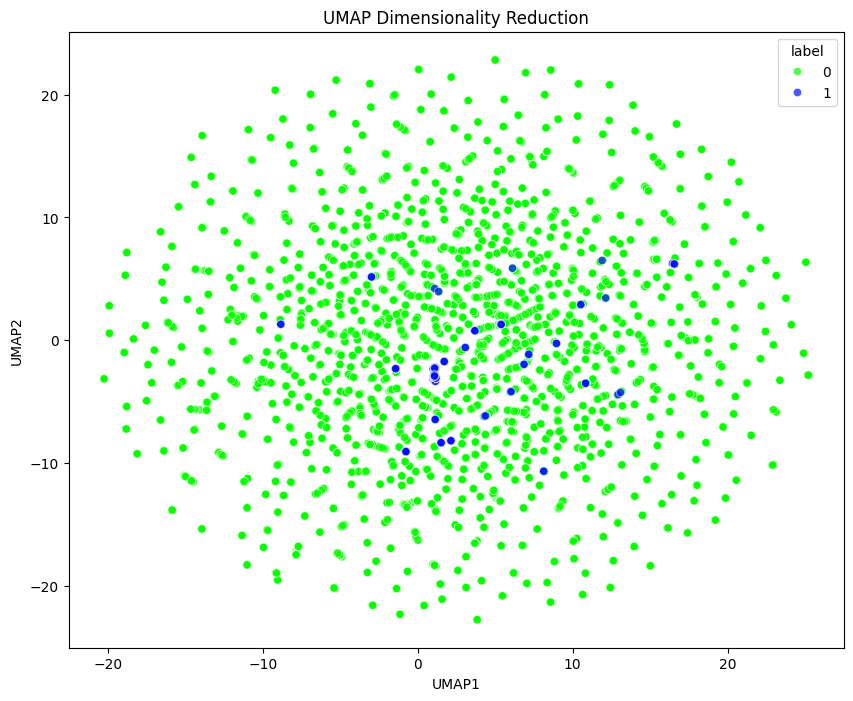

Dimensionality Reduction using UMAP Visualization -- Clustering tech for Anomaly Detection in Test Data


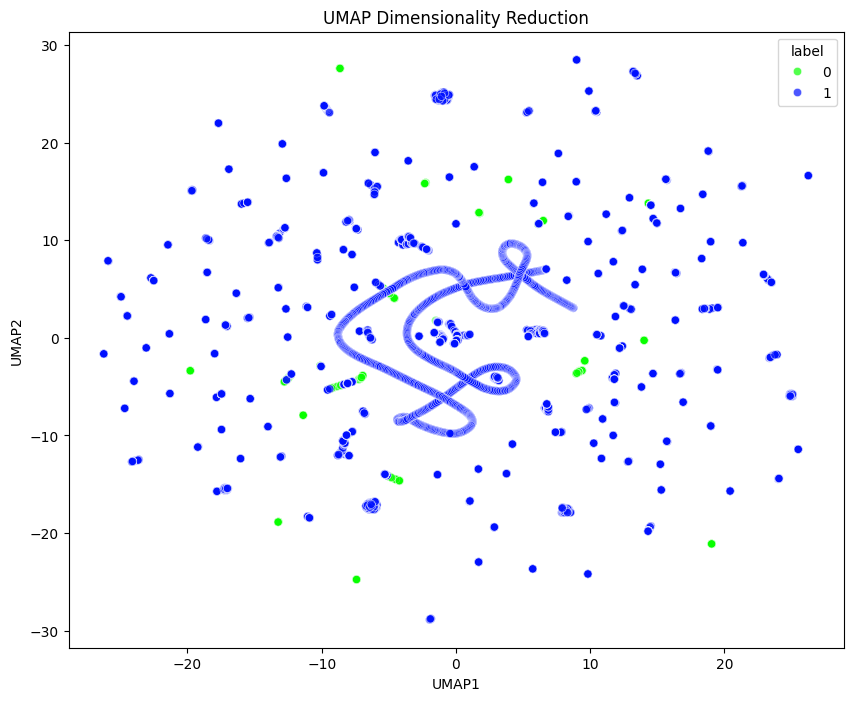

We report AUROC using an ensemble of 5 models for Once class SVM with SGD for anomaly detection
AUROC Score: 0.7780732560946173
iForest tries to characterise anomalous points in the data distribution using an ensemble of “isolation trees”. -- using Bootstrap Aggregation/Bagging.
The best params in I-forest : {'bootstrap': True, 'contamination': 0.05, 'max_features': 8, 'max_samples': 'auto', 'n_estimators': 50}
The best model in I-forest : IsolationForest(bootstrap=True, contamination=0.05, max_features=8,
                n_estimators=50, random_state=42)
Best Parameters: {'bootstrap': True, 'contamination': 0.05, 'max_features': 8, 'max_samples': 'auto', 'n_estimators': 50}
Predictions: [-1  1 -1 ... -1 -1 -1]
Anomaly Scores: [-0.01629925  0.10052513 -0.05736836 ... -0.05994264 -0.05994264
 -0.05994264]
AUROC Score: 0.3206346548394883
SGD One Class SVM using VAE
Checking for NaNs in X_train before VAE fitting: False
728/728 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
231/231 ━━━━━━━━━━━━━━━━━━━━

In [7]:
# Load and combine datasets
#csv_files = glob.glob("/kaggle/input/beth-dataset/*[!dns].csv")
'''csv_files=["labelled_2021may-ip-10-100-1-4-dns.csv","labelled_2021may-ip-10-100-1-26-dns.csv",
          "labelled_2021may-ip-10-100-1-95-dns.csv","labelled_2021may-ip-10-100-1-105-dns.csv",
          "labelled_2021may-ip-10-100-1-186-dns.csv","labelled_2021may-ubuntu-dns.csv"]'''
#csv_files=["labelled_training_data.csv"]
csv_files=["labelled_training_data.csv"]
#data = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
data = pd.read_csv("labelled_training_data.csv",on_bad_lines='skip',engine='python')
test_data = pd.read_csv('labelled_testing_data.csv', on_bad_lines='skip',engine='python')

print('Executing all the different algorithms by calling the above functions to understand performance of Anomaly Detection on Cyber Security Data')

print('Preprocessing the data ....')
df4=preprocess_logs(data)
df4test=preprocess_logs(test_data)
df4['sus'].value_counts(),df4test['sus'].value_counts()
print('Train x and Train y preprocessed ...')
train = df4.drop(['timestamp','evil','sus'],axis=1)
labels = df4['sus']
print('Test x and Test y preprocessed ...')
test = df4test.drop(['timestamp','evil','sus'],axis=1)
labels_test = df4test['sus']
train_1=np.array(train)
labels_1=np.array(labels)
test_1=np.array(test)
labels_test_1=np.array(labels_test)
train_1.shape,test_1.shape

#unsupervised methods -Clustering could potentially detect a large portion of the “anomalous” events
'''https://github.com/lmcinnes/umap'''
print('Dimensionality Reduction using UMAP Visualization -- Clustering tech for Anomaly Detection in Train Data')
#train_1=np.array(train)
#labels_1=np.array(labels)
UMAP_visual(train_1,labels_1)

print('Dimensionality Reduction using UMAP Visualization -- Clustering tech for Anomaly Detection in Test Data')
#test_1=np.array(test)
#labels_test_1=np.array(labels_test)
UMAP_visual(test_1,labels_test_1)

print('We report AUROC using an ensemble of 5 models for Once class SVM with SGD for anomaly detection')
SGDSvm(train,test,labels_test)

print('iForest tries to characterise anomalous points in the data distribution using an ensemble of “isolation trees”. -- using Bootstrap Aggregation/Bagging.')
I_forest(train_1,test_1,labels_test)

print('SGD One Class SVM using VAE')

X_train = train_1
X_test = test_1
y_test = labels_test_1
# X_ood = np.random.uniform(-4, 4, (7385, 14)) # Ensure dimensions match your data if used
print("Checking for NaNs in X_train before VAE fitting:", np.isnan(X_train).any())
# If this prints True, you need to go back to the preprocessing steps and ensure no NaNs are introduced or that they are handled correctly.

# Train VAE
input_dim = X_train.shape[1]
latent_dim = 10
vae, encoder = build_vae(input_dim, latent_dim)
# Ensure the input data for VAE training is float32 as expected by Keras
X_train = X_train.astype('float32')
# Normalize X_train to a range expected by the sigmoid activation in the decoder, e.g., [0, 1]
# This is crucial if your original feature values are not in this range.A MinMaxScaler is suitable here. Fit it on X_train before training the VAE.
minmax_scaler = MinMaxScaler()
X_train_scaled_for_vae = minmax_scaler.fit_transform(X_train)
# The VAE loss expects three tensors as y_true: x_true, z_mean (dummy), z_log_var (dummy)
# And three tensors as y_pred: x_decoded_mean, z_mean, z_log_var (from the VAE output)
# During fitting, we provide the actual data as y_true[0(x_true)], and placeholders for the other two.
# The model outputs [x_decoded_mean, z_mean, z_log_var] as y_pred.
# The custom loss function then uses these to calculate the total loss.

vae.fit(X_train_scaled_for_vae, # Pass only the actual input data as x
        [X_train_scaled_for_vae, np.zeros((X_train.shape[0], latent_dim)), np.zeros((X_train.shape[0], latent_dim))], # This is y_true passed to vae_loss
        epochs=20, batch_size=32, verbose=0)

# Extract features using the encoder
# Apply the same minmax scaling to the test data before encoding
X_test_scaled_for_vae = minmax_scaler.transform(X_test.astype('float32'))
X_train_encoded = encoder.predict(X_train_scaled_for_vae)
X_test_encoded = encoder.predict(X_test_scaled_for_vae)
# If using X_ood, scale it similarly
# X_ood_scaled_for_vae = minmax_scaler.transform(X_ood.astype('float32'))
# X_ood_encoded = encoder.predict(X_ood_scaled_for_vae)
X_train_scaled = X_train_encoded
X_test_scaled  = X_test_encoded
print("Checking for NaNs in X_train_scaled after scaling:", np.isnan(X_train_scaled).any())
print("Checking for NaNs in X_test_scaled after scaling:", np.isnan(X_test_scaled).any())

# Train One-Class SVM with SGD
svm = SGDOneClassSVM(nu=0.1, random_state=42)
svm.fit(X_train_scaled)
# Predict anomalies (-1: anomaly, 1: inlier)
y_test = labels_test_1
# Assuming you are not using the random X_ood for prediction against real data
# y_ood = -np.ones(X_ood_scaled.shape[0])
# y_scores = svm.decision_function(np.vstack([X_test_scaled, X_ood_scaled]))
# y_true = np.hstack([y_test, y_ood])

# Predict only on your actual test data
y_scores = svm.decision_function(X_test_scaled)
y_true = y_test

# Calculate AUROC
auroc = roc_auc_score(y_true, y_scores)
print(f"AUROC: {auroc:.4f}")